In [1]:
from __future__ import absolute_import, division, print_function

import functools
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import tensorflow as tf
from pprint import pprint

In [2]:
version = tf.__version__
executing_eagerly = tf.executing_eagerly()
gpu_available = tf.test.is_gpu_available()
print('Tensorflow version: {}\n'
      'Executing eagerly: {}\n'
      'GPU available: {}'
      .format(version, 
              executing_eagerly, 
              gpu_available))

Tensorflow version: 2.0.0
Executing eagerly: True
GPU available: True


## Generating Discrete Harmonic Functions on the Square

The Harmonic functions on the square A of size N are those functions that satisfy:
$$f(i, j) = \frac{1}{4}\bigg(f(i-1, j) + f(i+1, j) + f(i,j-1) + f(i,j+1)\bigg)$$
for all $i,j \in \{1, 2, ..., N-1\}$.  These functions are uniquely determined by their values on the boundary of the square: $i\in\{0,N\}\text{ or }j\in\{0,N\}$.  

What follows is a summary of http://www.math.uchicago.edu/~lawler/reu.pdf, section 1.5.

Let $e_k$ refer to the function defined on $\partial A$ that is equal to 1 at the $k$th position at the bottom of the square and is equal 0 elsewhere.  Then the harmonic function on the interior of the square that is equal to $e_k$ on the boundary is given by:
$$H_{(N, e_k)}(x_1, x_2) = \frac{2}{N-1}\sum_{j=1}^{N-1}\frac{1}{\sinh(\beta_j)}\sin\left(\frac{j\pi k}{N}\right)\sinh\left(\frac{\beta_jx_1}{N}\right)\sin\left(\frac{j\pi x_2}{N}\right)$$
where $\beta_j\text{ for }j\in\{1, 2, ..., N-1\}$ solves:
$$ \cosh\left(\frac{\beta_j}{N}\right) + \cos\left(\frac{j\pi}{N}\right) = 2$$
These functions, combined with similar functions for the other sides of the square, form a basis for the space of all harmonic functions on the interior of the square.  This is implemented below.

In [3]:
harmonic_basis_cache={}

def generate_beta(n):
    return [n*(np.arccosh(2-np.cos(j*np.pi/n))) for j in range(1,n)]
  
def poisson_kernel_square_raw(n, y, x_1, x_2):
    beta = generate_beta(n)
    h = [np.sinh(beta[j-1] * x_1 / n) 
        * np.sin(j * np.pi * x_2 / n) for j in range(1, n)]
    c = [1/np.sinh(beta[j-1]) 
        * np.sin(j * np.pi * y / n) for j in range(1, n)]
    return 2/(n) * sum([c[j-1] * h[j-1] for j in range(1, n)])
  
def poisson_kernel_square(n, y):
    return lambda x_1, x_2: poisson_kernel_square_raw(n, y, x_1, x_2)
  
    
def harmonic_basis(n, k):
    if (n,k) in harmonic_basis_cache.keys():
        return harmonic_basis_cache[n,k]
    x = np.zeros(shape=[n+1, n+1])
    x[n,k] = 1
    H = poisson_kernel_square(n, k)
    for i in range(1, n):
        for j in range(1, n):
            x[i, j] = H(i, j)
    harmonic_basis_cache[n,k] = x
    return x
  
# This is O(n^3) at the moment.
# This is due to each of n basis functions taking O(n^2) steps to compute.
# Can this be improved?  Do we care?
def generate_harmonic_one_side(n, y, side='lower'):
    lower = np.sum([y[j-1] * harmonic_basis(n,j) for j in range(1, n)], axis=0)
    if side == 'upper':
        return np.flip(lower, axis=0)
    if side == 'left':
        return np.rot90(lower, k=3)
    if side == 'right':
        return np.rot90(np.flip(lower, axis=0), k=3)
    if side == 'lower':
        return lower

def generate_harmonic(n, y):
    """Here y specifies the entire boundary, going in order of upper, left, right, lower."""
    upper = generate_harmonic_one_side(n, y[:n-1], side='upper')
    left = generate_harmonic_one_side(n, y[n-1:2*n-2], side='left')
    right = generate_harmonic_one_side(n, y[2*n-2:3*n-3], side='right')
    lower = generate_harmonic_one_side(n, y[3*n-3:], side='lower')
    return upper + left + right + lower

In [4]:
def is_harmonic_at_point(x, i, j, tol=.000001, verbose=False):
    diff = np.abs(x[i, j] - np.mean([x[i-1,j], x[i+1,j], x[i,j-1], x[i,j+1]])) 
    if verbose:
        print("|{} - {}| = {}".format(x[i,j], 
                                      np.mean([x[i-1,j], x[i+1,j], x[i,j-1], x[i,j+1]]), 
                                      diff))
    return diff <= tol
  
def is_harmonic(x, n, tol=.000001, verbose=False):
    for i in range(1, n):
        for j in range(1, n):
            if not is_harmonic_at_point(x, i, j, tol=tol, verbose=verbose):
                if verbose:
                    print((i,j))
                return False
    return True

## Generating Non-Harmonic Functions.

The question of what to use as a negative for the model deserves a lot of thought.  At present I have two approaches: 

In the first approach, I use \\((N+1)^2\\) independent Gaussian random variables to generate non-harmonic functions.  The likelihood that these will be harmonic is negligible.  

In the second approach I generate a harmonic function, and add a gaussian density to the result.  Since the gaussian is not harmonic (it in particular violates the maximum modulus principle), the resulting sum is not harmonic.

In [5]:
def generate_nonharmonic(n):
    x = np.random.randn(n+1,n+1)
    x[0,0] = 0.
    x[0,n] = 0.
    x[n,0] = 0.
    x[n,n] = 0.
    return x

In [6]:
grv_cache={}

# This is slow, need to make better use of numpy to 
# generate these, possibly with memoization as above.
def generate_gaussian(n, strength):
    mean = np.random.randint(1,n, size=2)
    cov = (n/2 - .5) * np.random.random(size=2) + .5
    amplitude = strength * np.random.choice([1,-1])
    rv = multivariate_normal(mean=mean, cov=cov)
    x = rv.pdf(np.array(np.meshgrid(np.arange(n+1), np.arange(n+1))).T)
    return amplitude * x

def generate_harmonic_plus_noise(n, y, strength=.1):
    harmonic = generate_harmonic(n, y)
    output = harmonic + generate_gaussian(n, strength=strength)
    return output

In [7]:
def visualize(examples, n, cmap='cividis'):
    num_examples = len(examples)
    fig, axes = plt.subplots(1, num_examples, figsize=(n+1,n+1))
    if num_examples == 1:
        axes.imshow(examples[0], cmap=cmap)
        axes.axis('off')
        plt.show()
        return
    axes = axes.flatten()
    for x, ax in zip(examples, axes):
        ax.imshow(x, cmap=cmap)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## Data Preparation

In [8]:
def harmonic_data_generator(n):
    while True:
        if np.random.rand() < .5:
            y = np.random.randn(4*(n-1))
            yield np.reshape(generate_harmonic(n,y), (n+1, n+1)).astype(np.float32), 1
        else:
            yield np.reshape(generate_nonharmonic(n), (n+1, n+1)).astype(np.float32), 0

In [9]:
def mixed_harmonic_data_generator(n):
    while True:
        x = np.random.rand()
        if x < .25:
            y = np.random.randn(4*(n-1))
            yield np.reshape(generate_harmonic(n,y), (n+1, n+1)).astype(np.float32), 1
        if x < .5:
            y = np.random.choice([-1, 0, 1, 2, 10], p=[.39, .3, .2, .1, .01], size=(4*(n-1),))
            yield np.reshape(generate_harmonic(n,y), (n+1, n+1)).astype(np.float32), 1
        elif x < .7:
            y = np.random.randn(4*(n-1))
            strength = np.random.rand()
            yield np.reshape(generate_harmonic_plus_noise(n,y,strength=strength), (n+1, n+1)).astype(np.float32), 0
        elif x < .9:
            y = np.random.choice([-1, 0, 1, 2, 10], p=[.39, .3, .2, .1, .01], size=(4*(n-1),))
            strength = np.random.rand()
            yield np.reshape(generate_harmonic_plus_noise(n,y,strength=strength), (n+1, n+1)).astype(np.float32), 0
        elif x < 1.:
            yield np.reshape(generate_nonharmonic(n), (n+1, n+1)).astype(np.float32), 0

In [10]:
def visualize_dataset(dataset, n, num_examples=5, cmap='cividis'):
    examples = [item for item in dataset.take(num_examples)]
    fig, axes = plt.subplots(1, num_examples, figsize=(n+1,n+1))
    axes = axes.flatten()
    for x, ax in zip(examples, axes):
        ax.imshow(x[0], cmap=cmap, vmin=-3, vmax=3)
        if x[1]:
            ax.set_title("Harmonic")
        else:
            ax.set_title("Nonharmonic")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [11]:
n=30
dataset = tf.data.Dataset.from_generator(mixed_harmonic_data_generator, 
                                         args=[n], 
                                         output_types=(tf.float32, tf.bool), 
                                         output_shapes = ((n+1,n+1), ()))

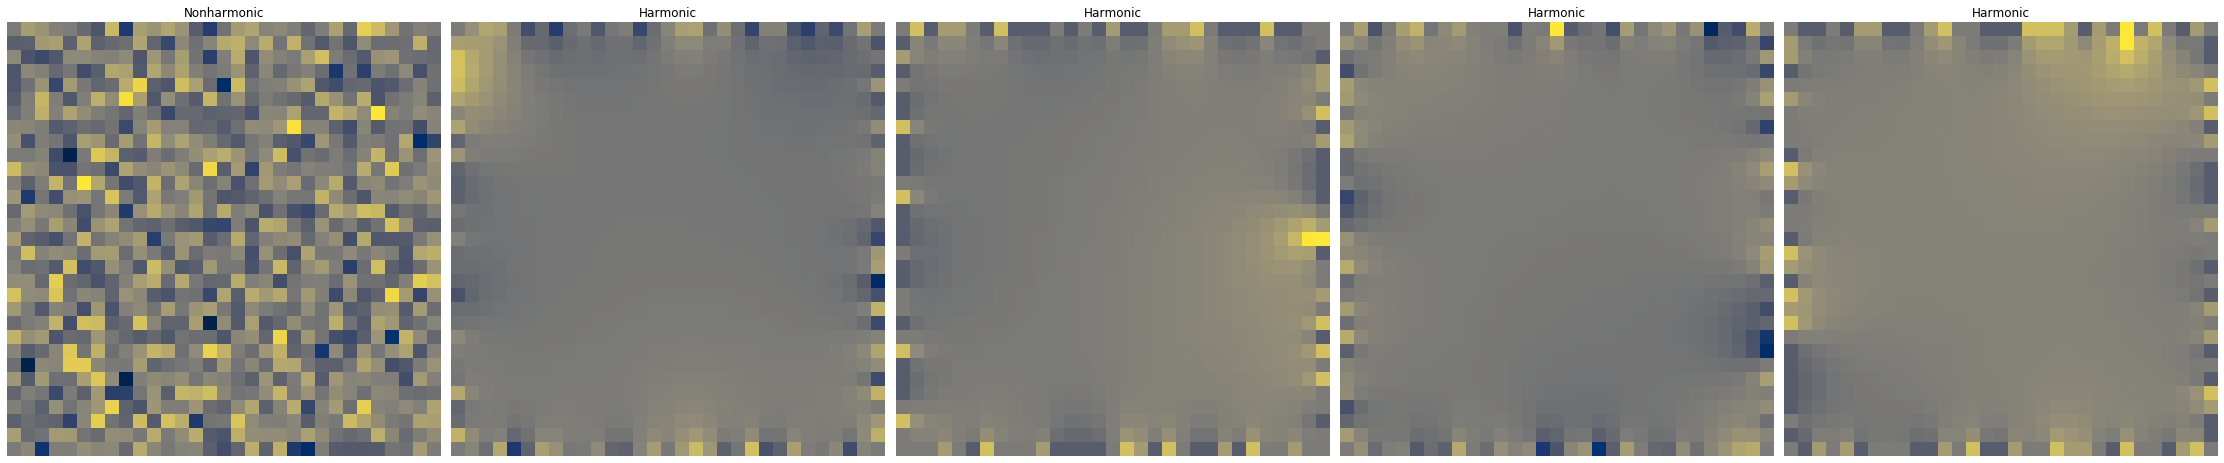

In [12]:
visualize_dataset(dataset, n, num_examples=5)

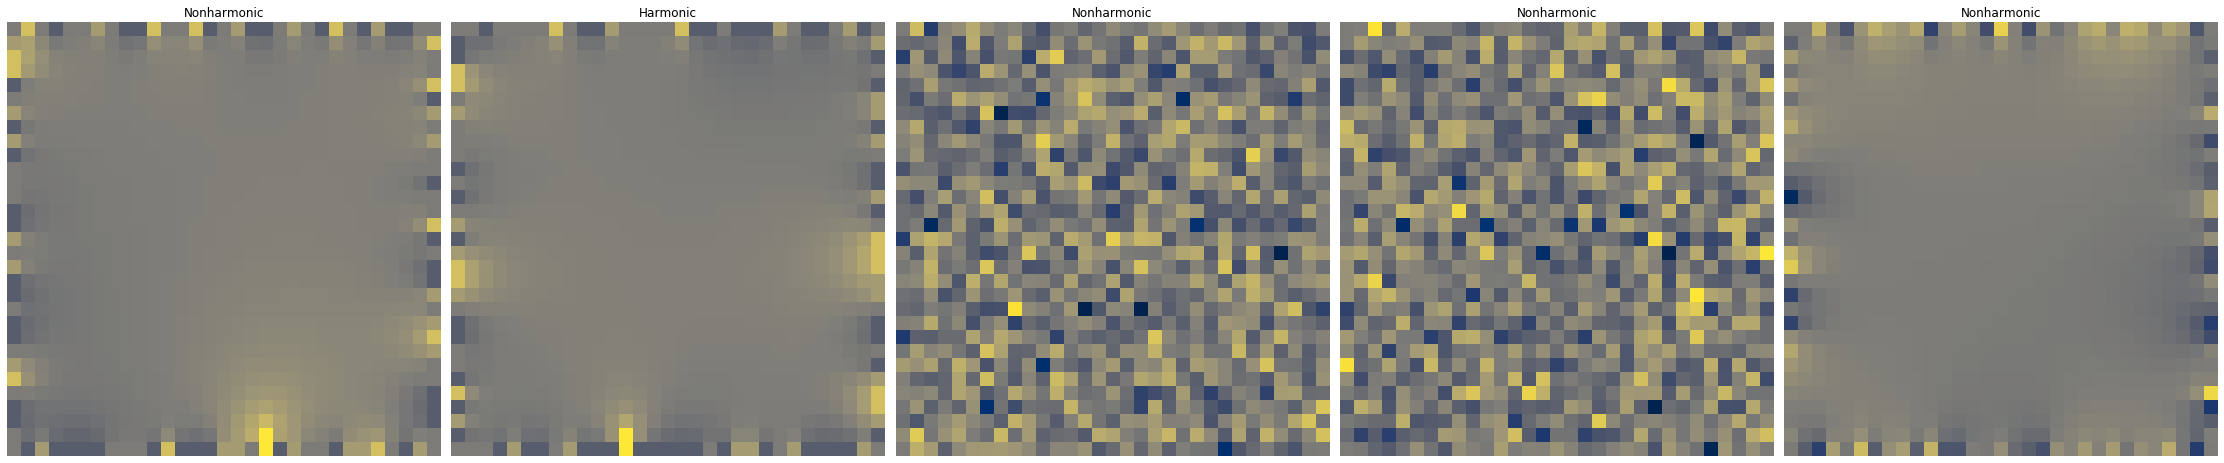

In [13]:
visualize_dataset(dataset, n, num_examples=5)

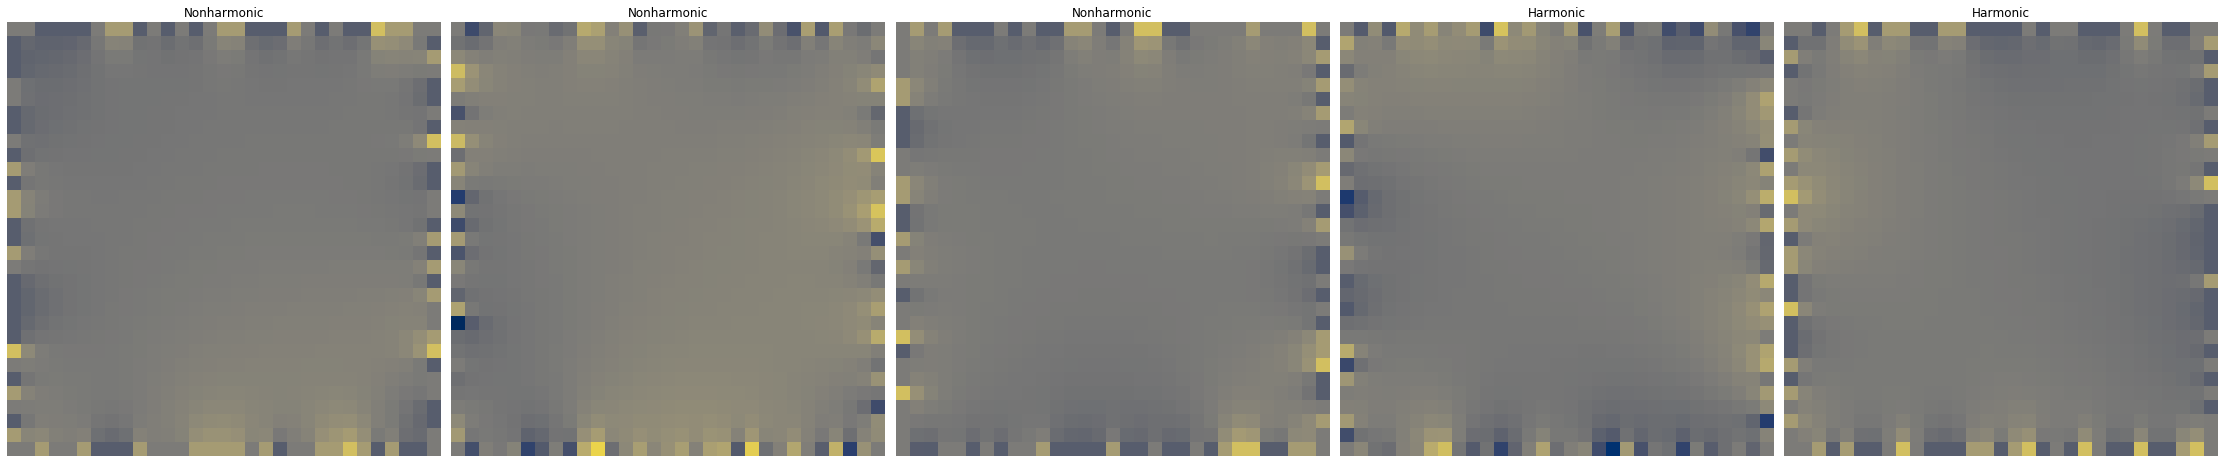

In [14]:
visualize_dataset(dataset, n, num_examples=5)

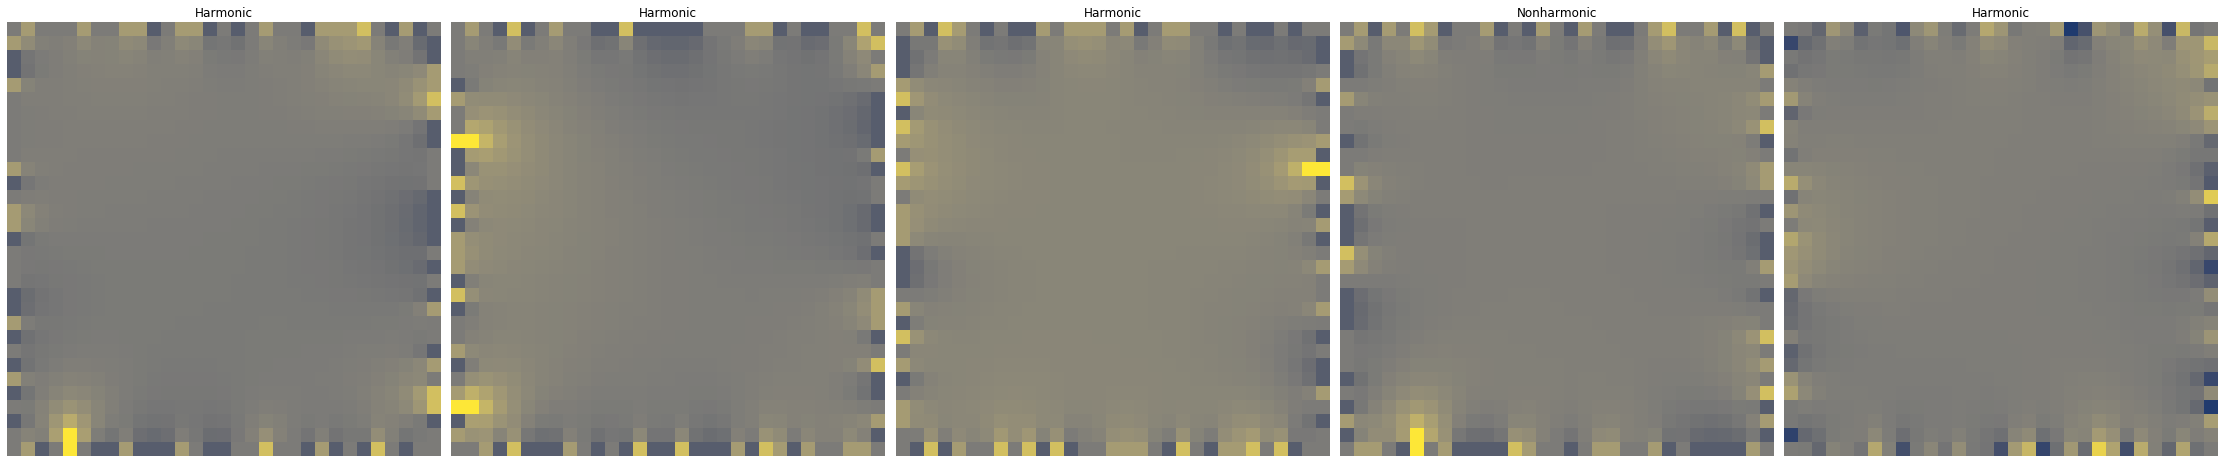

In [15]:
visualize_dataset(dataset, n, num_examples=5)

## Controllers

In [16]:
class DiffEqController(tf.keras.callbacks.Callback):
    
    def __init__(self, precisions, verbose=False):
        super(DiffEqController, self).__init__()
        self.precisions = precisions
        self.verbose = verbose
    
    def on_epoch_begin(self, epoch, logs):
        precision = precisions[epoch]
        if self.verbose:
            print("Precision={}".format(precision))
        output_weights = np.array([[-2/(precision**2)], [-2/(precision**2)]])
        output_biases = np.array([1/(4*(precision)**2)])
        self.model.layers[-1].set_weights((output_weights, output_biases))

In [17]:
class DiffEqForcer(tf.keras.callbacks.Callback):
    
    def __init__(self, rate, verbose=False):
        super(DiffEqForcer, self).__init__()
        self.rate = rate
        self.verbose = verbose
    
    def on_epoch_begin(self, epoch, logs):
        if self.verbose:
            pass
        output_weights, output_biases = self.model.layers[-1].get_weights()
        self.model.layers[-1].set_weights((output_weights * self.rate, output_biases * self.rate))

## Constraints

In [18]:
import tensorflow.keras.backend as K

In [19]:
class ProbMeasure(tf.keras.constraints.Constraint):
    """Constrains the weights incident to each hidden unit to be a probability measure.
    """

    def __init__(self, axis=0):
        self.axis = axis

    def __call__(self, w):
        w = w * K.cast(K.greater_equal(w, 0.), K.floatx())
        return w / (K.epsilon() + K.sum(K.abs(w),
                                        axis=self.axis,
                                        keepdims=True))

    def get_config(self):
        return {'axis': self.axis}

In [20]:
class NonPos(tf.keras.constraints.Constraint):
    """Constrains the weights incident to each hidden unit to Negative.
    """

    def __init__(self):
        pass

    def __call__(self, w):
        w = w * K.cast(K.less_equal(w, 0.), K.floatx())
        return w

## Models

In [21]:
class DiffeqModel(tf.keras.Model):
    
    def __init__(self, n, filter_size):
        super(DiffeqModel, self).__init__(name='diffeq_model')
        self.n = n
        self.reshape = tf.keras.layers.Reshape((n+1,n+1,1), input_shape=(n+1,n+1))
        self.conv2D = tf.keras.layers.Conv2D(filter_size, 
                                             kernel_size=3,
                                             input_shape=(n+1, n+1, 1),
                                             kernel_regularizer=tf.keras.regularizers.l2(.001),)
        self.dense = tf.keras.layers.Dense(1, 
                                           activation='relu', 
                                           kernel_constraint=ProbMeasure(),
                                           kernel_regularizer=tf.keras.regularizers.l1(.01))
        self.max_pool = tf.keras.layers.MaxPool2D(pool_size=n-1)
        self.flatten = tf.keras.layers.Flatten()
        output_kernel_initializer = tf.keras.initializers.Constant([[-1., -1.]])
        output_bias_initializer = tf.keras.initializers.Constant([.2])
        self.output_layer = tf.keras.layers.Dense(1, 
                                                  activation='sigmoid', 
                                                  kernel_initializer = output_kernel_initializer,
                                                  bias_initializer = output_bias_initializer,
                                                  trainable=False)
        
    def call(self, input_tensor, training=False):
        x = self.reshape(input_tensor)
        x = self.conv2D(x)
        x1 = tf.nn.relu(x)
        x2 = tf.nn.relu(-1*x)
        x1 = self.dense(x1)
        x2 = self.dense(x2)
        x = tf.concat([x1, x2], axis=-1)
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.output_layer(x)

In [22]:
def get_model(n, filter_size):

    sequential_model = tf.keras.Sequential([
        tf.keras.layers.Reshape((n+1,n+1,1), input_shape=(n+1,n+1)),
        tf.keras.layers.Conv2D(filter_size, 
                               kernel_size=3,
                               input_shape=(n+1, n+1, 1),
                               kernel_regularizer=tf.keras.regularizers.l2(.001),),
        tf.keras.layers.Lambda(lambda x: K.abs(x)),
        tf.keras.layers.GlobalMaxPool2D(),
        tf.keras.layers.Dense(1, 
                              kernel_constraint=NonPos(),
                              activation='sigmoid')
    ])
    
    return sequential_model


## Training Convolutional Net on Basic Data

In [141]:
n=10
epochs=20

In [142]:
dataset = tf.data.Dataset.from_generator(harmonic_data_generator,
                                         args=[n], 
                                         output_types=(tf.float32, tf.bool), 
                                         output_shapes = ((n+1,n+1), ()))
mixed_dataset = tf.data.Dataset.from_generator(mixed_harmonic_data_generator, 
                                               args=[n], 
                                               output_types=(tf.float32, tf.bool), 
                                               output_shapes = ((n+1,n+1), ()))

In [143]:
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((n+1,n+1,1), input_shape=(n+1,n+1)),
    tf.keras.layers.Conv2D(32, 
                           kernel_size=3,
                           input_shape=(n+1, n+1, 1),
                           activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l1(.001)),
    tf.keras.layers.Dense(1, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
], name="Conv2D-Easy")

In [144]:
model.summary()

Model: "Conv2D-Easy"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 11, 11, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 32)          320       
_________________________________________________________________
dense_15 (Dense)             (None, 9, 9, 1)           33        
_________________________________________________________________
flatten_7 (Flatten)          (None, 81)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 82        
Total params: 435
Trainable params: 435
Non-trainable params: 0
_________________________________________________________________


In [145]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [146]:
h = model.fit(dataset.batch(64), epochs=epochs, steps_per_epoch=100)

Train for 100 steps
Epoch 1/20
100/100 [==============================] - 3s 27ms/step - loss: 0.5544 - accuracy: 0.6852
Epoch 2/20
100/100 [==============================] - 2s 21ms/step - loss: 0.2035 - accuracy: 0.9952
Epoch 3/20
100/100 [==============================] - 2s 20ms/step - loss: 0.0542 - accuracy: 1.0000
Epoch 4/20
100/100 [==============================] - 2s 20ms/step - loss: 0.0341 - accuracy: 1.0000
Epoch 5/20
100/100 [==============================] - 2s 19ms/step - loss: 0.0290 - accuracy: 1.0000
Epoch 6/20
100/100 [==============================] - 2s 20ms/step - loss: 0.0263 - accuracy: 0.9998
Epoch 7/20
100/100 [==============================] - 2s 19ms/step - loss: 0.0240 - accuracy: 1.0000
Epoch 8/20
100/100 [==============================] - 2s 19ms/step - loss: 0.0225 - accuracy: 1.0000
Epoch 9/20
100/100 [==============================] - 2s 21ms/step - loss: 0.0208 - accuracy: 1.0000
Epoch 10/20
100/100 [==============================] - 2s 20ms/step - l

In [147]:
def test_on_harmonic_perturbations(n, y):
    x = generate_harmonic(n, y)
    visualize([x], n)
    perturbations = [1., .5, .1, .05, .01, .0025, .001]
    harmonic_prediction = model.predict(x.reshape(1, n+1, n+1))[0,0]
    print('Harmonic: {}'.format(harmonic_prediction))
    for perturbation in perturbations:
        y = x.copy()
        y[2, 2] = y[2,2] - perturbation
        prediction = model.predict(y.reshape(1, n+1, n+1))[0,0]
        print('Perturbation {}: {}'.format(perturbation, prediction))

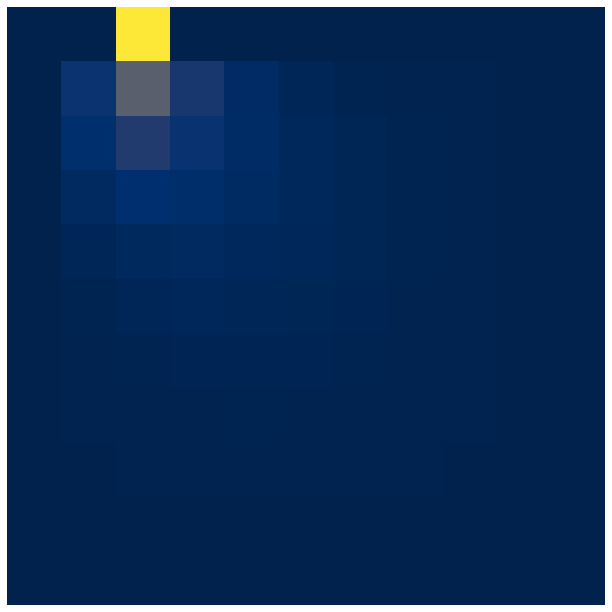

Harmonic: 0.7468590140342712
Perturbation 1.0: 0.7607502937316895
Perturbation 0.5: 0.7549980878829956
Perturbation 0.1: 0.7475346326828003
Perturbation 0.05: 0.747052788734436
Perturbation 0.01: 0.7468770146369934
Perturbation 0.0025: 0.7468634843826294
Perturbation 0.001: 0.7468608617782593


In [150]:
test_on_harmonic_perturbations(10, np.identity(40)[1])


## Training Convolutional Net on Mixed Data

In [184]:
n=10
epochs=20

In [185]:
dataset = tf.data.Dataset.from_generator(harmonic_data_generator,
                                         args=[n], 
                                         output_types=(tf.float32, tf.bool), 
                                         output_shapes = ((n+1,n+1), ()))
mixed_dataset = tf.data.Dataset.from_generator(mixed_harmonic_data_generator, 
                                               args=[n], 
                                               output_types=(tf.float32, tf.bool), 
                                               output_shapes = ((n+1,n+1), ()))

In [186]:
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((n+1,n+1,1), input_shape=(n+1,n+1)),
    tf.keras.layers.Conv2D(32, 
                           kernel_size=3,
                           input_shape=(n+1, n+1, 1),
                           activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l1(.001)),
    tf.keras.layers.Dense(1, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
], name="Conv2D-Easy")

In [187]:
model.summary()

Model: "Conv2D-Easy"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_11 (Reshape)         (None, 11, 11, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 9, 32)          320       
_________________________________________________________________
dense_19 (Dense)             (None, 9, 9, 1)           33        
_________________________________________________________________
flatten_8 (Flatten)          (None, 81)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 82        
Total params: 435
Trainable params: 435
Non-trainable params: 0
_________________________________________________________________


In [188]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [189]:
h = model.fit(mixed_dataset.batch(64), epochs=epochs, steps_per_epoch=100)

Train for 100 steps
Epoch 1/20
100/100 [==============================] - 4s 45ms/step - loss: 0.6978 - accuracy: 0.5869
Epoch 2/20
100/100 [==============================] - 4s 41ms/step - loss: 0.6320 - accuracy: 0.6650
Epoch 3/20
100/100 [==============================] - 4s 41ms/step - loss: 0.6221 - accuracy: 0.6631
Epoch 4/20
100/100 [==============================] - 4s 39ms/step - loss: 0.6169 - accuracy: 0.6717
Epoch 5/20
100/100 [==============================] - 4s 38ms/step - loss: 0.6070 - accuracy: 0.6764
Epoch 6/20
100/100 [==============================] - 4s 37ms/step - loss: 0.6040 - accuracy: 0.6844
Epoch 7/20
100/100 [==============================] - 4s 37ms/step - loss: 0.6038 - accuracy: 0.6836
Epoch 8/20
100/100 [==============================] - 4s 38ms/step - loss: 0.5991 - accuracy: 0.6812
Epoch 9/20
100/100 [==============================] - 4s 38ms/step - loss: 0.5987 - accuracy: 0.6820
Epoch 10/20
100/100 [==============================] - 4s 40ms/step - l

In [192]:
def test_on_harmonic_perturbations(n, y):
    x = generate_harmonic(n, y)
    visualize([x], n)
    perturbations = [1., .5, .1, .05, .01, .0025, .001]
    harmonic_prediction = model.predict(x.reshape(1, n+1, n+1))[0,0]
    print('Harmonic: {}'.format(harmonic_prediction))
    for perturbation in perturbations:
        y = x.copy()
        y[2, 2] = y[2,2] - perturbation
        prediction = model.predict(y.reshape(1, n+1, n+1))[0,0]
        print('Perturbation {}: {}'.format(perturbation, prediction))

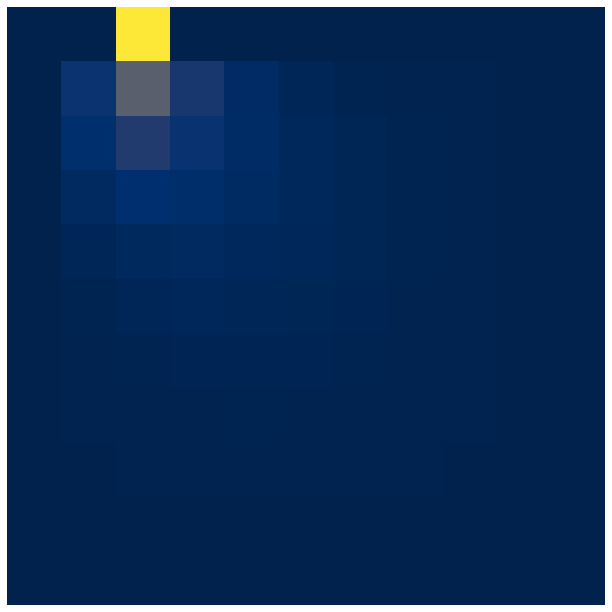

Harmonic: 0.5520232915878296
Perturbation 1.0: 0.5240264534950256
Perturbation 0.5: 0.546442985534668
Perturbation 0.1: 0.5520268082618713
Perturbation 0.05: 0.5520250797271729
Perturbation 0.01: 0.5520236492156982
Perturbation 0.0025: 0.5520233511924744
Perturbation 0.001: 0.5520233511924744


In [193]:
test_on_harmonic_perturbations(10, np.identity(40)[1])


## A Net with Constraints

In [263]:
n=10
epochs=20

In [264]:
dataset = tf.data.Dataset.from_generator(harmonic_data_generator,
                                         args=[n], 
                                         output_types=(tf.float32, tf.bool), 
                                         output_shapes = ((n+1,n+1), ()))

In [265]:
mixed_dataset = tf.data.Dataset.from_generator(mixed_harmonic_data_generator, 
                                               args=[n], 
                                               output_types=(tf.float32, tf.bool), 
                                               output_shapes = ((n+1,n+1), ()))

In [266]:
filter_size = 32
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((n+1,n+1,1), input_shape=(n+1,n+1)),
    tf.keras.layers.Conv2D(filter_size, 
                           kernel_size=3,
                           input_shape=(n+1, n+1, 1),
                           kernel_regularizer=tf.keras.regularizers.l2(.001),),
    tf.keras.layers.Lambda(lambda x: K.abs(x)),
    tf.keras.layers.GlobalMaxPool2D(),
    tf.keras.layers.Dense(1, 
                          kernel_constraint=NonPos(),
                          activation='sigmoid')
])

In [267]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_19 (Reshape)         (None, 11, 11, 1)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 9, 9, 32)          320       
_________________________________________________________________
lambda_9 (Lambda)            (None, 9, 9, 32)          0         
_________________________________________________________________
global_max_pooling2d_9 (Glob (None, 32)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [268]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [269]:
h = model.fit(dataset.batch(64), epochs=epochs, steps_per_epoch=100)

Train for 100 steps
Epoch 1/20
100/100 [==============================] - 2s 23ms/step - loss: 0.6480 - accuracy: 0.5091
Epoch 2/20
100/100 [==============================] - 2s 19ms/step - loss: 0.4217 - accuracy: 0.7620
Epoch 3/20
100/100 [==============================] - 2s 20ms/step - loss: 0.3205 - accuracy: 1.0000
Epoch 4/20
100/100 [==============================] - 2s 20ms/step - loss: 0.2871 - accuracy: 1.0000
Epoch 5/20
100/100 [==============================] - 2s 19ms/step - loss: 0.2651 - accuracy: 1.0000
Epoch 6/20
100/100 [==============================] - 2s 20ms/step - loss: 0.2448 - accuracy: 1.0000
Epoch 7/20
100/100 [==============================] - 2s 20ms/step - loss: 0.2317 - accuracy: 1.0000
Epoch 8/20
100/100 [==============================] - 2s 19ms/step - loss: 0.2110 - accuracy: 1.0000
Epoch 9/20
100/100 [==============================] - 2s 19ms/step - loss: 0.1981 - accuracy: 1.0000
Epoch 10/20
100/100 [==============================] - 2s 19ms/step - l

In [283]:
model.layers[-1].get_weights()

[array([[-0.6745315 ],
        [ 0.        ],
        [-0.5584671 ],
        [ 0.        ],
        [-0.43295133],
        [-0.5764653 ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [-0.5545966 ],
        [-0.8267692 ],
        [-0.40676802],
        [ 0.        ],
        [-0.6742531 ],
        [-0.59604836],
        [-0.6945672 ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [-0.20473   ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [-0.7432787 ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [-0.47625238],
        [ 0.        ],
        [-0.48529273]], dtype=float32), array([1.5933983], dtype=float32)]

In [284]:
indices = np.argsort(model.layers[-1].get_weights()[0].flatten())

In [285]:
layer = model.layers[1].get_weights()[0][:,:,:,indices[2]].flatten()

In [286]:
layer / layer[4]

array([-3.4619454e-05, -2.4991931e-01,  9.4669842e-05, -2.4994785e-01,
        1.0000000e+00, -2.5004935e-01, -6.6370507e-05, -2.4987631e-01,
       -7.9561360e-05], dtype=float32)

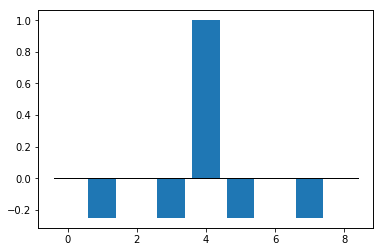

In [287]:
plt.bar(range(9), layer / layer[4])
axes2 = plt.twiny()
x = np.arange(9)
y = np.zeros(9)
axes2.plot(x,y, linewidth=1, color='black')
axes2.set_xticks([])
plt.show()

In [288]:
model.layers[-1].get_weights()

[array([[-0.6745315 ],
        [ 0.        ],
        [-0.5584671 ],
        [ 0.        ],
        [-0.43295133],
        [-0.5764653 ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [-0.5545966 ],
        [-0.8267692 ],
        [-0.40676802],
        [ 0.        ],
        [-0.6742531 ],
        [-0.59604836],
        [-0.6945672 ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [-0.20473   ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [-0.7432787 ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [-0.47625238],
        [ 0.        ],
        [-0.48529273]], dtype=float32), array([1.5933983], dtype=float32)]

In [289]:
ce = np.zeros((n+1, n+1))
for i in range(n+1):
    for j in range(n+1):
        ce[i,j] = (n)/2 - np.max([np.abs((n)/2 - i), np.abs((n)/2 - j)])

In [290]:
ce

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 2., 2., 2., 2., 2., 2., 2., 1., 0.],
       [0., 1., 2., 3., 3., 3., 3., 3., 2., 1., 0.],
       [0., 1., 2., 3., 4., 4., 4., 3., 2., 1., 0.],
       [0., 1., 2., 3., 4., 5., 4., 3., 2., 1., 0.],
       [0., 1., 2., 3., 4., 4., 4., 3., 2., 1., 0.],
       [0., 1., 2., 3., 3., 3., 3., 3., 2., 1., 0.],
       [0., 1., 2., 2., 2., 2., 2., 2., 2., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [291]:
model.predict(ce.reshape(1,n+1, n+1))

array([[0.20703006]], dtype=float32)

In [292]:
model.predict(-1*ce.reshape(1,n+1, n+1))

array([[0.20708118]], dtype=float32)

In [293]:
def test_on_harmonic_perturbations(n, y):
    x = generate_harmonic(n, y)
    visualize([x], n)
    perturbations = [1., .5, .1, .05, .01, .0025, .001]
    harmonic_prediction = model.predict(x.reshape(1, n+1, n+1))[0,0]
    print('Harmonic: {}'.format(harmonic_prediction))
    for perturbation in perturbations:
        y = x.copy()
        y[2, 2] = y[2,2] - perturbation
        prediction = model.predict(y.reshape(1, n+1, n+1))[0,0]
        print('Perturbation {}: {}'.format(perturbation, prediction))

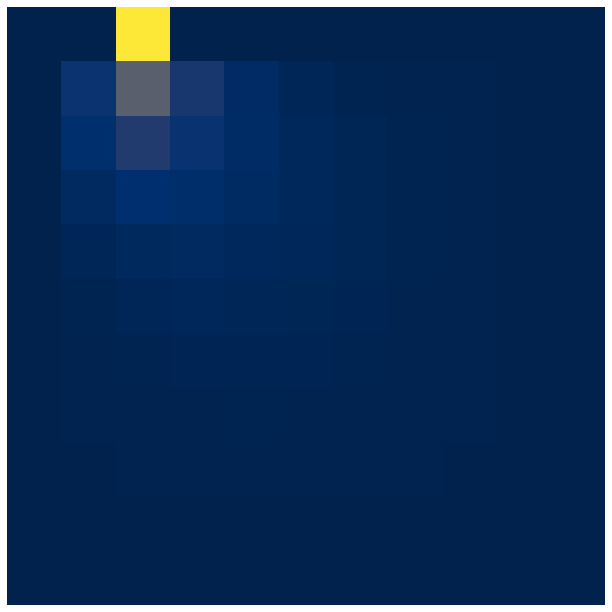

Harmonic: 0.8309580683708191
Perturbation 1.0: 0.20679888129234314
Perturbation 0.5: 0.531112015247345
Perturbation 0.1: 0.7857946753501892
Perturbation 0.05: 0.809482991695404
Perturbation 0.01: 0.8269507884979248
Perturbation 0.0025: 0.8300812840461731
Perturbation 0.001: 0.83069908618927


In [294]:
test_on_harmonic_perturbations(10, np.identity(40)[1])

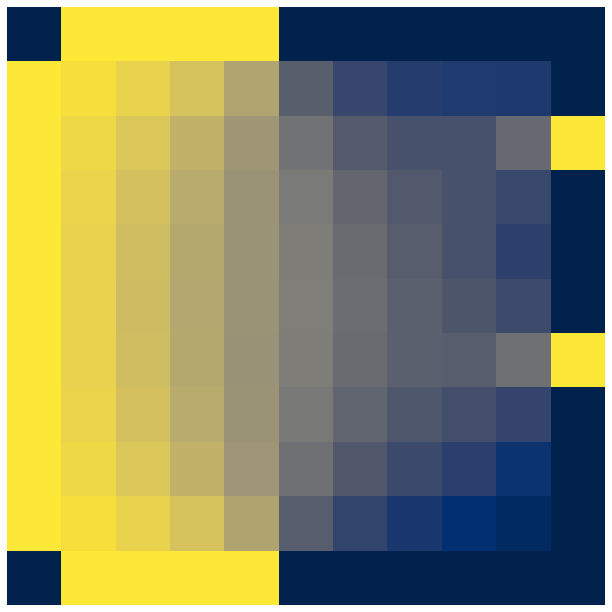

Harmonic: 0.8307867050170898
Perturbation 1.0: 0.20673975348472595
Perturbation 0.5: 0.5310221314430237
Perturbation 0.1: 0.7857338786125183
Perturbation 0.05: 0.8094273209571838
Perturbation 0.01: 0.8268991112709045
Perturbation 0.0025: 0.8299936652183533
Perturbation 0.001: 0.8305290937423706


In [295]:
test_on_harmonic_perturbations(10, [1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,0,0,0,1,1,1,1,0,0,0,0,0])


## Another Variant on Training

In [255]:
n=10
epochs=20

In [256]:
dataset = tf.data.Dataset.from_generator(harmonic_data_generator,
                                         args=[n], 
                                         output_types=(tf.float32, tf.bool), 
                                         output_shapes = ((n+1,n+1), ()))

In [257]:
mixed_dataset = tf.data.Dataset.from_generator(mixed_harmonic_data_generator, 
                                               args=[n], 
                                               output_types=(tf.float32, tf.bool), 
                                               output_shapes = ((n+1,n+1), ()))

In [258]:
model = get_model(n, 32)

In [259]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [260]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_18 (Reshape)         (None, 11, 11, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 9, 9, 32)          320       
_________________________________________________________________
lambda_8 (Lambda)            (None, 9, 9, 32)          0         
_________________________________________________________________
global_max_pooling2d_8 (Glob (None, 32)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 33        
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [261]:
def geometric_schedule(rate=.9):
    return lambda epoch, lr: lr*rate

lr_schedule = tf.keras.callbacks.LearningRateScheduler(geometric_schedule())
diff_eq_forcer = DiffEqForcer(1.1)

In [262]:
h = model.fit(mixed_dataset.batch(64), epochs=epochs, steps_per_epoch=100, callbacks=[diff_eq_forcer])

Train for 100 steps
Epoch 1/20
100/100 [==============================] - 4s 41ms/step - loss: 1.0403 - accuracy: 0.4086
Epoch 2/20
100/100 [==============================] - 4s 36ms/step - loss: 0.7180 - accuracy: 0.4561
Epoch 3/20
100/100 [==============================] - 4s 36ms/step - loss: 0.6502 - accuracy: 0.6781
Epoch 4/20
100/100 [==============================] - 4s 37ms/step - loss: 0.6359 - accuracy: 0.6753
Epoch 5/20
100/100 [==============================] - 4s 37ms/step - loss: 0.6220 - accuracy: 0.6755
Epoch 6/20
100/100 [==============================] - 4s 37ms/step - loss: 0.6140 - accuracy: 0.6744
Epoch 7/20
100/100 [==============================] - 4s 40ms/step - loss: 0.6079 - accuracy: 0.6714
Epoch 8/20
100/100 [==============================] - 4s 41ms/step - loss: 0.6047 - accuracy: 0.6745
Epoch 9/20
100/100 [==============================] - 4s 39ms/step - loss: 0.5914 - accuracy: 0.6947
Epoch 10/20
100/100 [==============================] - 4s 38ms/step - l


## Another Variant on Training

In [72]:
n=30

In [73]:
dataset = tf.data.Dataset.from_generator(harmonic_data_generator,
                                         args=[n], 
                                         output_types=(tf.float32, tf.bool), 
                                         output_shapes = ((n+1,n+1), ()))

In [74]:
mixed_dataset = tf.data.Dataset.from_generator(mixed_harmonic_data_generator, 
                                               args=[n], 
                                               output_types=(tf.float32, tf.bool), 
                                               output_shapes = ((n+1,n+1), ()))

In [75]:
model = get_model(n, 32)

In [76]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [77]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 31, 31, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 32)        320       
_________________________________________________________________
lambda_3 (Lambda)            (None, 29, 29, 32)        0         
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


In [78]:
epochs = 60
precisions = [1., 1., 1., 1., 1.,
              .7, .7, .7, .7, .7,
              .5, .5, .5, .5, .5,
              .35, .35, .35, .35, .35,
              .2, .2, .2, .2, .2,
              .1, .1, .1, .1, .1,
              .05, .05, .05, .05, .05,
              .03, .03, .03, .03, .03,
              .01, .01, .01, .01, .01,
              .01, .01, .01, .01, .01,
              .01, .01, .01, .01, .01,
              .01, .01, .01, .01, .01]

diffeq_conroller = DiffEqController(precisions)

In [79]:
def diff_eq_schedule(epoch, lr, precisions):
    if epoch == 0:
        return lr
    old_precision, new_precision = precisions[epoch-1], precisions[epoch]
    if new_precision == old_precision:
        return (4/5) * lr
    return min(.001, 2*(new_precision ** 2))

def get_diff_eq_schedule(precisions):
    return lambda epoch, lr: diff_eq_schedule(epoch, lr, precisions)

def geometric_schedule(rate=.9):
    return lambda epoch, lr: lr*rate

lr_schedule = tf.keras.callbacks.LearningRateScheduler(get_diff_eq_schedule(precisions))
diff_eq_forcer = DiffEqForcer(1.5)

In [80]:
h = model.fit(dataset.batch(64), epochs=epochs, steps_per_epoch=100, callbacks=[diff_eq_forcer, lr_schedule])

Train for 100 steps
Epoch 1/60
100/100 [==============================] - 5s 46ms/step - loss: 0.8803 - accuracy: 0.4930
Epoch 2/60
100/100 [==============================] - 4s 42ms/step - loss: 0.4236 - accuracy: 0.7161
Epoch 3/60
100/100 [==============================] - 4s 42ms/step - loss: 0.2782 - accuracy: 1.0000
Epoch 4/60
100/100 [==============================] - 4s 41ms/step - loss: 0.2384 - accuracy: 1.0000
Epoch 5/60
100/100 [==============================] - 4s 41ms/step - loss: 0.1844 - accuracy: 1.0000
Epoch 6/60
100/100 [==============================] - 4s 42ms/step - loss: 0.1301 - accuracy: 1.0000
Epoch 7/60
100/100 [==============================] - 4s 42ms/step - loss: 0.0700 - accuracy: 1.0000
Epoch 8/60
100/100 [==============================] - 4s 42ms/step - loss: 0.0260 - accuracy: 1.0000
Epoch 9/60
100/100 [==============================] - 4s 42ms/step - loss: 0.0066 - accuracy: 1.0000
Epoch 10/60
100/100 [==============================] - 4s 42ms/step - l

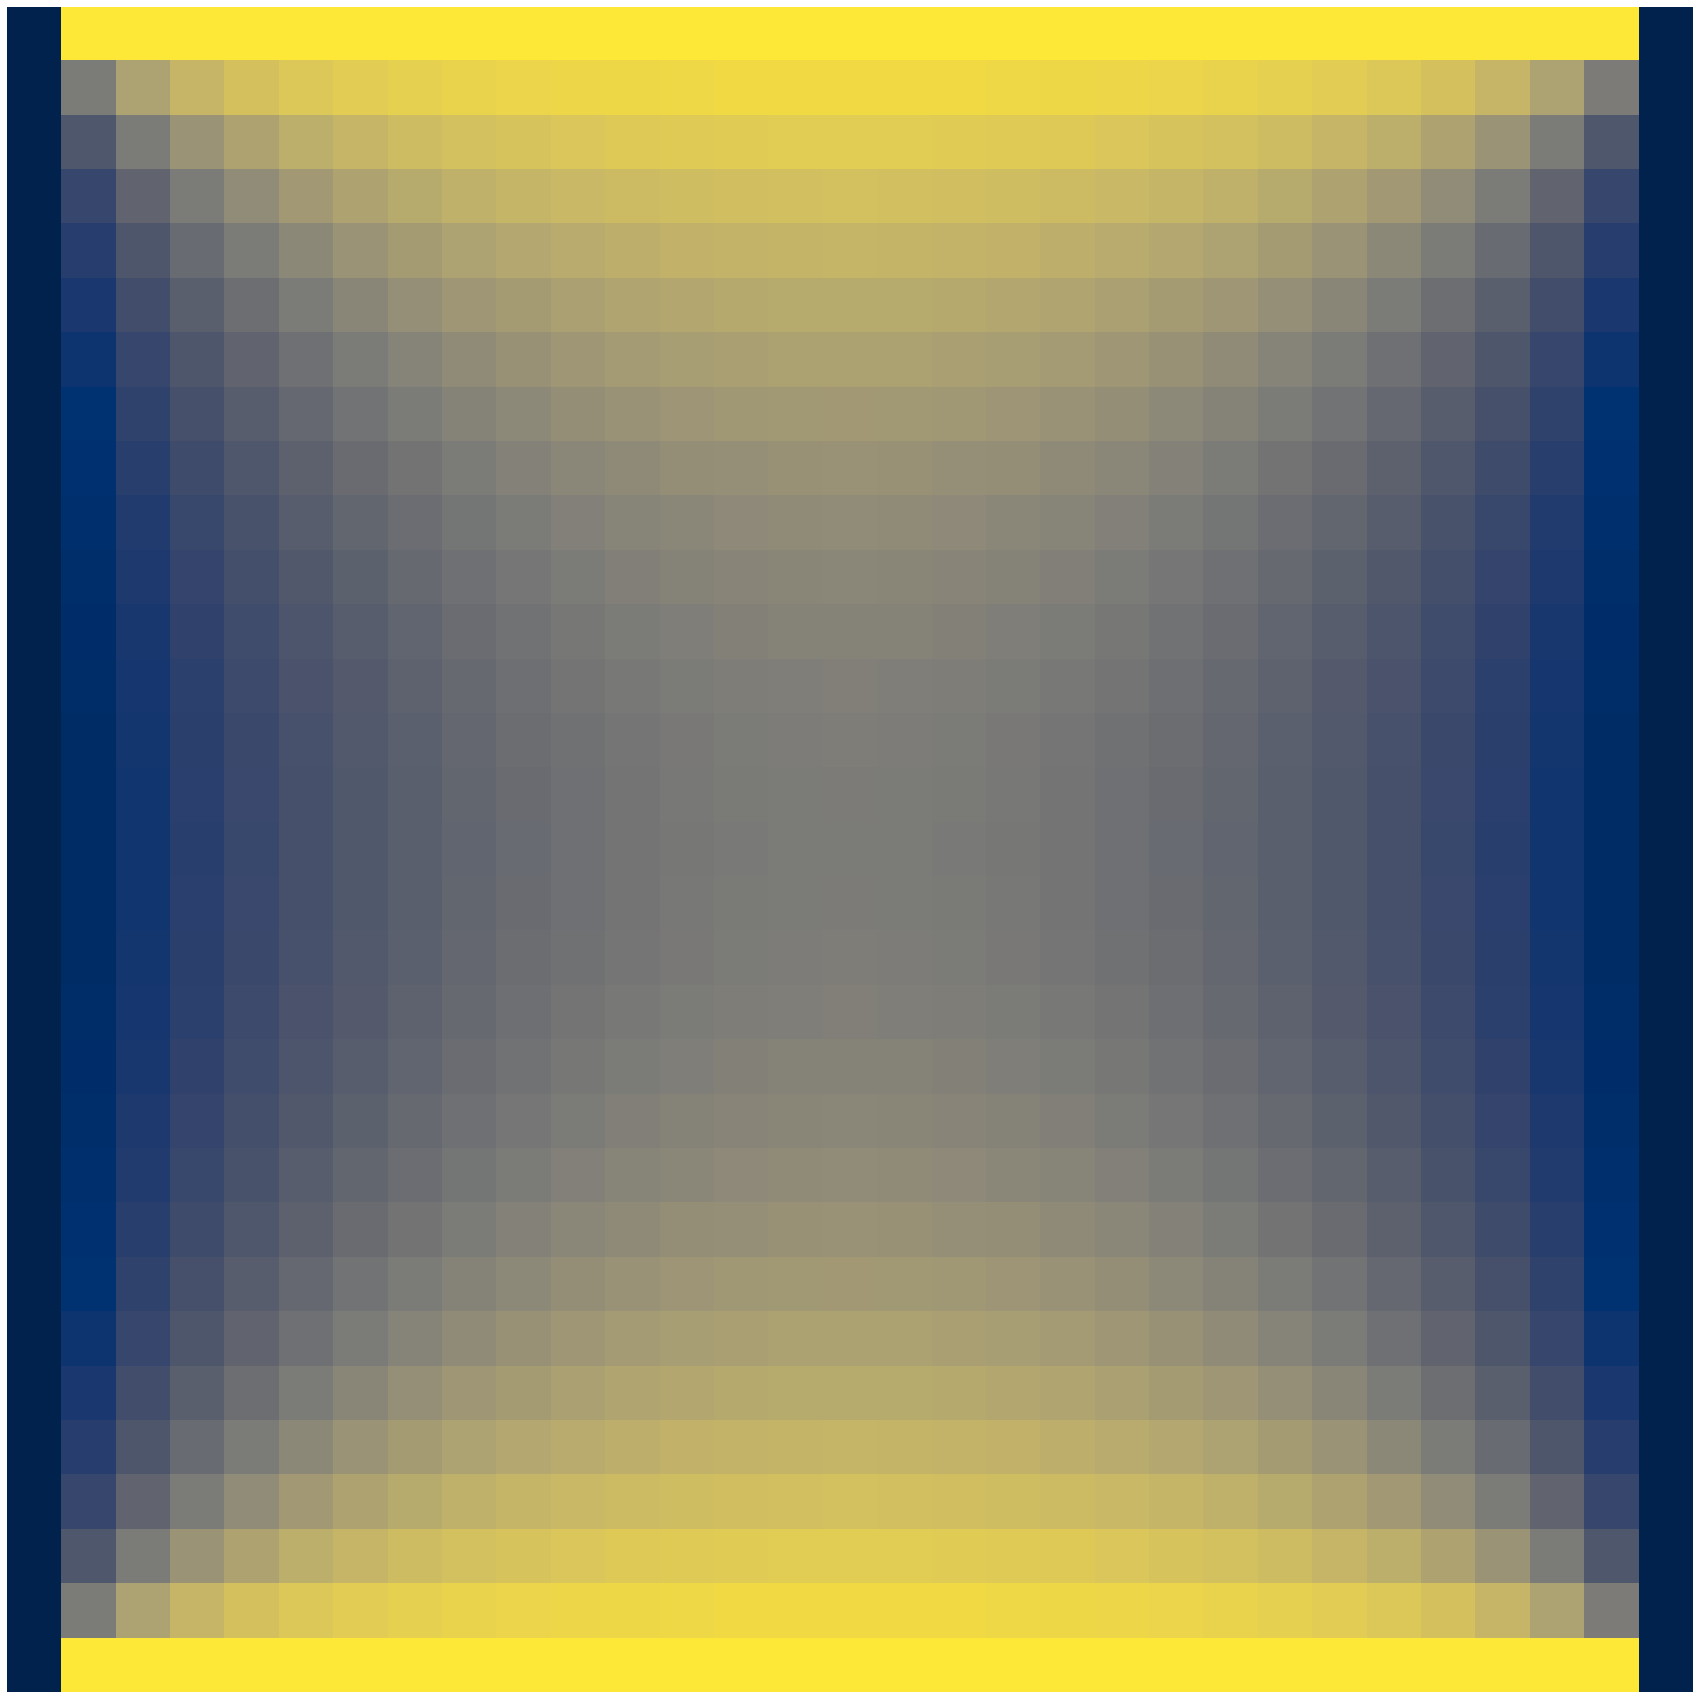

Harmonic: 1.0
Perturbation 1.0: 0.0
Perturbation 0.5: 0.0
Perturbation 0.1: 1.0
Perturbation 0.05: 1.0
Perturbation 0.01: 1.0
Perturbation 0.0025: 1.0
Perturbation 0.001: 1.0


In [81]:
test_on_harmonic_perturbations(30, [1 for i in range(29)]+[0 for i in range(29)]+[0 for i in range(29)]+[1 for i in range(29)])

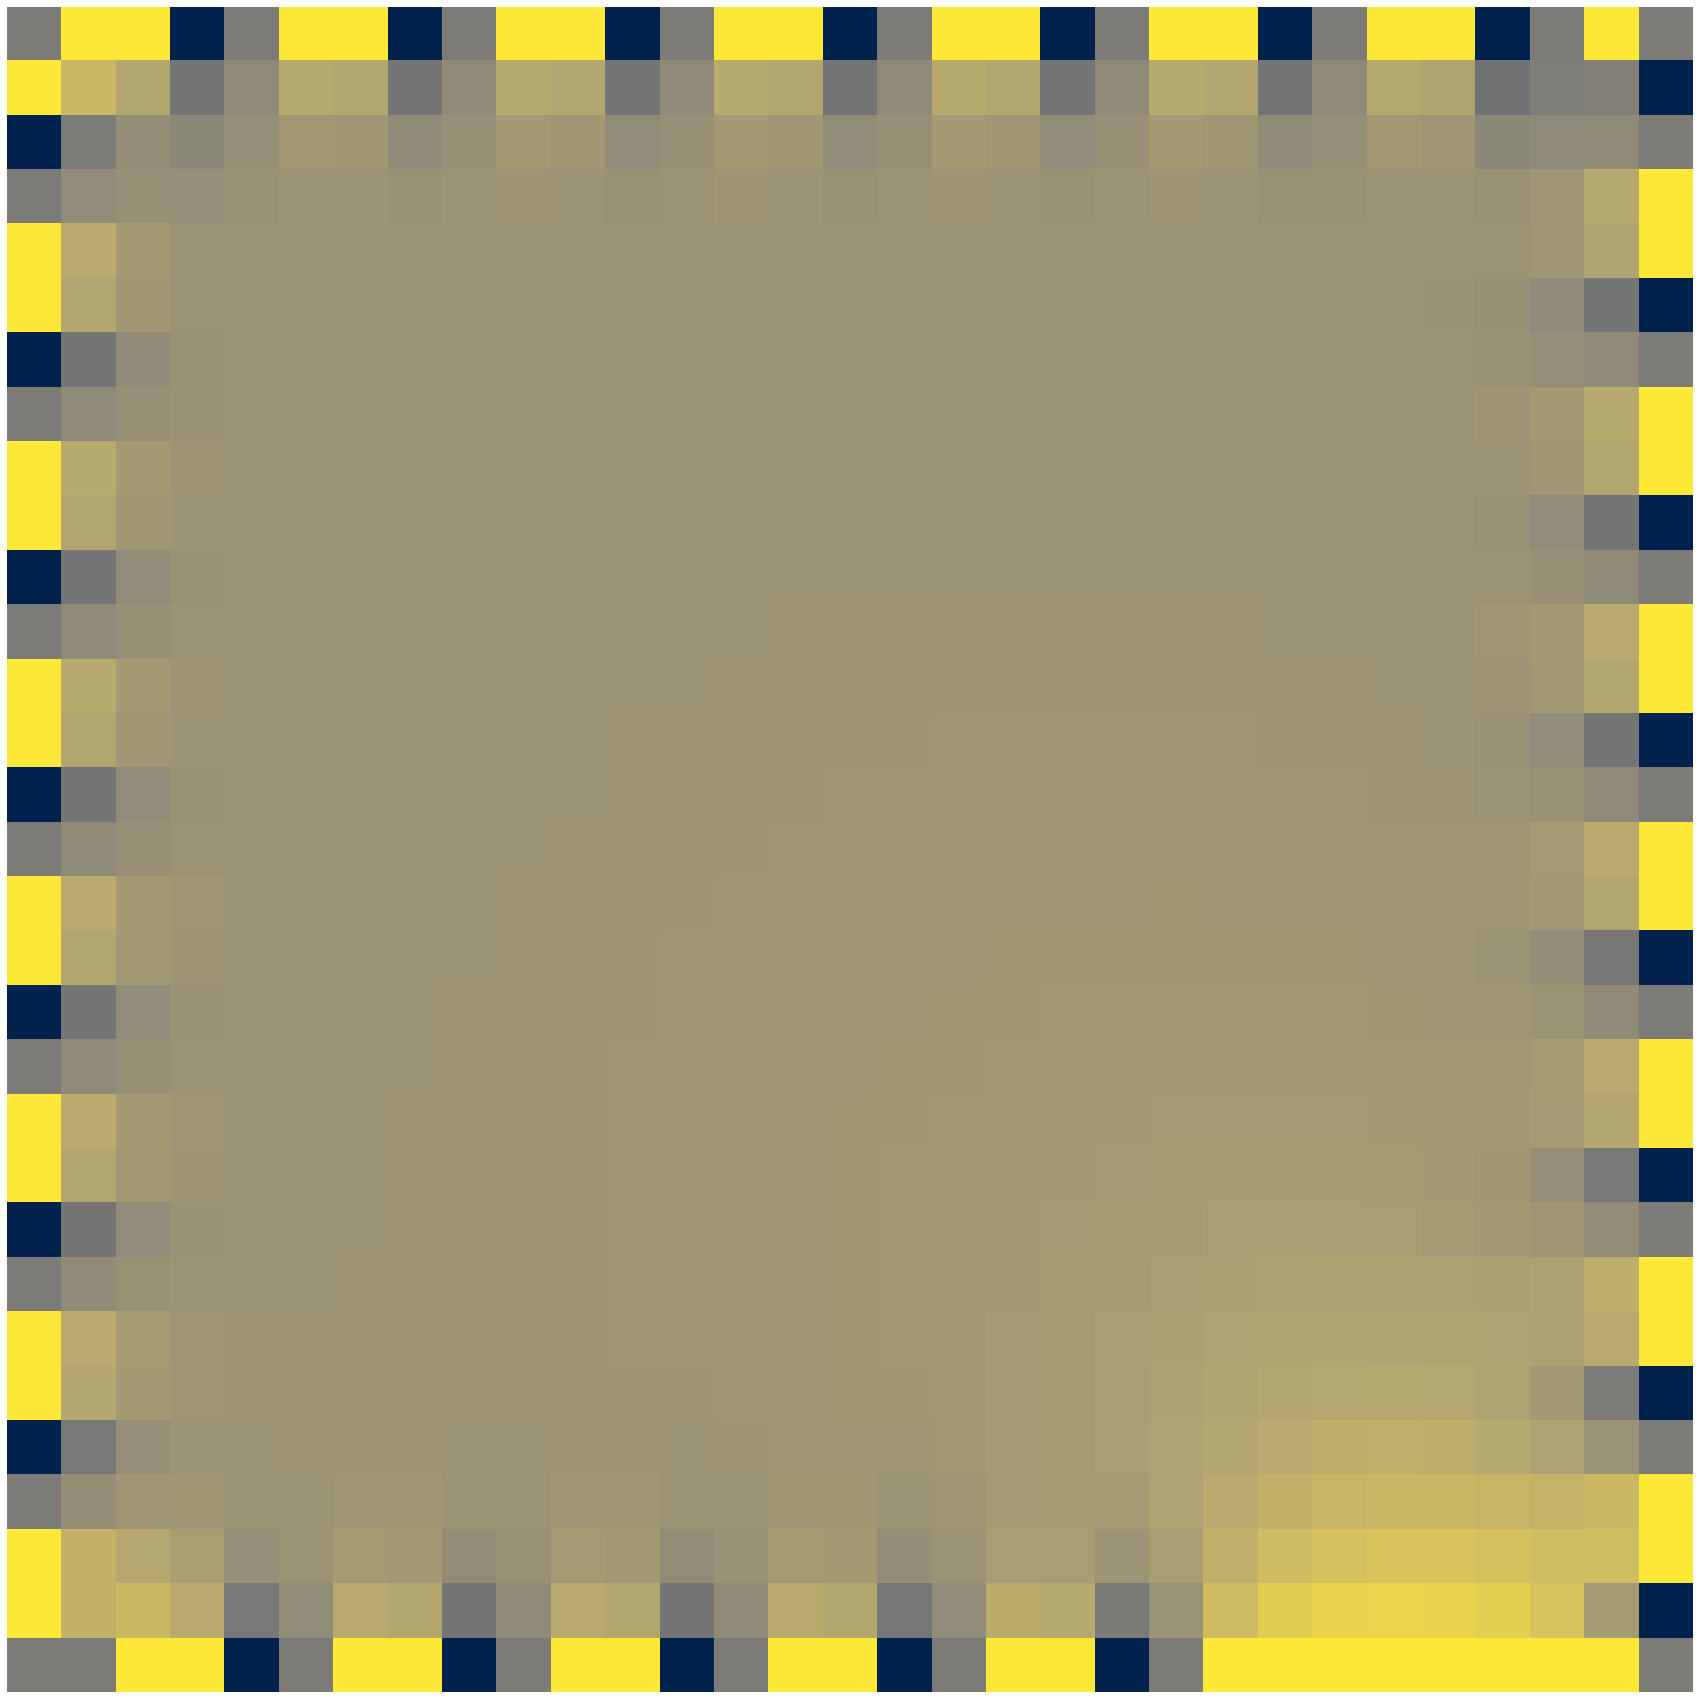

Harmonic: 1.0
Perturbation 1.0: 0.0
Perturbation 0.5: 0.0
Perturbation 0.1: 1.0
Perturbation 0.05: 1.0
Perturbation 0.01: 1.0
Perturbation 0.0025: 1.0
Perturbation 0.001: 1.0


In [82]:
test_on_harmonic_perturbations(30, np.concatenate([[1,1,-1,0] for i in range(29-2)] + [[1,1,1,1,1,1,1,1]]))

In [ ]:
test_on_harmonic_pertubations(10, 10*[1,1,1,1,.5,.2,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,.2,.4,1,1,0])

In [ ]:
test_on_harmonic_pertubations(10, np.identity(81)[0])

In [ ]:
test_on_harmonic_pertubations(10, 20*np.identity(81)[4])

In [ ]:
test_on_harmonic_pertubations(10, np.identity(36)[2]+np.identity(36)[3]+np.identity(36)[4]+np.identity(36)[30]+np.identity(36)[31]+np.identity(36)[32])

In [ ]:
model.layers[-1].get_weights()

In [ ]:
layer = model.layers[1].get_weights()[0][:,:,:,1].flatten()
layer.reshape(1,3,3)/ layer[4]

In [ ]:
plt.bar(range(9), layer / layer[4])
axes2 = plt.twiny()
x = np.arange(9)
y = np.zeros(9)
axes2.plot(x,y, linewidth=1, color='black')
axes2.set_xticks([])
plt.show()